<a href="https://colab.research.google.com/github/brit228/DS-Unit-2-Sprint-2-Linear-Regression/blob/master/module4-Model%20Diagnostics/Model_Diagnostics_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Model Diagnostics

The purpose of this assigment is introduce you to a new library for linear regression called statmodels which is much better suited for inferential modeling than sklearn. This assignment is also to familiarize yourself with some of most important procedures for improving the interpretability of regression coefficients. You will also perform important statistical tests that will help establish that whether or not important assumptions that safeguard the interpretability of OLS coefficients have been met. 

We will continue to use the Ames Housing Dataset so that you can focus on the techniques and not on cleaning/getting associated with a brand new dataset.

## 1.1 Choose an X and Y variable from your dataset and use them to create a Seaborn Regplot

/usr/local/lib/python3.6/dist-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


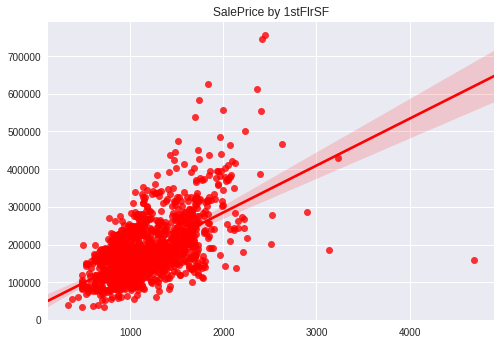

In [6]:
import seaborn as sns
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from scipy import stats

df = pd.read_csv("https://raw.githubusercontent.com/ryanleeallred/datasets/master/Ames%20Housing%20Data/train.csv", header=0)

Y_col = 'SalePrice'

df["DateSold"] = pd.to_numeric(pd.to_datetime(df["YrSold"]*100+df["MoSold"],format='%Y%m'))
df = df.drop(columns=['YrSold', 'MoSold'])

na_col = [x for x in df if df[x].isna().sum() != 0 and df[x].dtype in ["int64", "float64"] and x not in ["Id", Y_col]]
for c in na_col:
  df[c] = df[c].fillna(df[c].mean())

for c in df:
  if df[c].dtype == 'object':
    c_df = pd.get_dummies(df[c])
    for v in c_df:
      df["{}:{}".format(c,v)] = c_df[v]

X_col = '1stFlrSF'

fig = sns.regplot(df[X_col].values, df[Y_col].values, color='red').set_title('{} by {}'.format(Y_col, X_col))

## 1.2 Now using the X variables that you feel like will be the best predictors of y use statsmodel to run the multiple regression between these variables and Y. You don't need to use every X variable in your dataset, in fact it's probably better if you don't. Just pick ones that you have already cleaned that seem the most relevant to house prices.

In [7]:
n_col = 10
y = df[Y_col]
r2_vals = []
c_vals = []
for x in df:
  if df[x].dtype in ["int64", "float64"] and x not in ["Id", Y_col]:
    r2_vals.append(stats.pearsonr(df[x], y)[0] ** 2)
    c_vals.append(x)

X = df[[c_vals[z] for z in [r2_vals.index(x) for x in sorted(r2_vals)[-10:]]]]
X1 = sm.add_constant(X)

model = sm.OLS(y, X1).fit()
predictions = model.predict(X1) 

print_model = model.summary()
print(print_model)

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.774
Model:                            OLS   Adj. R-squared:                  0.772
Method:                 Least Squares   F-statistic:                     495.4
Date:                Thu, 17 Jan 2019   Prob (F-statistic):               0.00
Time:                        23:20:20   Log-Likelihood:                -17459.
No. Observations:                1460   AIC:                         3.494e+04
Df Residuals:                    1449   BIC:                         3.500e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const        -1.186e+06   1.29e+05     -9.187   

## 1.3 Identify the standard errors and P-Values of these coefficients in the output table. What is the interpretation of the P-values here?

In [8]:
print(model.pvalues)

# p values represent the probability for each term to not be associated
# with the response (i.e. SalesPrice). Generally, a p value of 0.05 or less
# indicates that a term is associated with the response for the model.

# In this case, TotRmsAbvGrd and GarageArea are not highly associated with
# the response, while the other terms are.

const           1.356200e-19
YearRemodAdd    3.467105e-06
YearBuilt       1.150539e-07
TotRmsAbvGrd    9.764038e-01
FullBath        1.145705e-02
1stFlrSF        4.097244e-03
TotalBsmtSF     4.085733e-06
GarageArea      1.473837e-01
GarageCars      6.386199e-04
GrLivArea       2.860875e-32
OverallQual     5.166583e-56
dtype: float64


## 1.4 Remove outliers from your dataset and run the regression again. Do you see a change in some coefficients? Which seem to move the most?

In [9]:
for c in X:
  Q1 = df[c].quantile(0.25)
  Q3 = df[c].quantile(0.75)
  IQR = Q3 - Q1
  df = df[(df[c] >= Q1 - 1.5 * IQR) & (df[c] <= Q3 + 1.5 * IQR)]
X2 = df[[c for c in X]]
X2 = sm.add_constant(X2)
y = df[Y_col]

model2 = sm.OLS(y, X2).fit()
predictions = model2.predict(X2)

print_model2 = model2.summary()
print(print_model2)

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.816
Model:                            OLS   Adj. R-squared:                  0.815
Method:                 Least Squares   F-statistic:                     581.3
Date:                Thu, 17 Jan 2019   Prob (F-statistic):               0.00
Time:                        23:20:20   Log-Likelihood:                -15354.
No. Observations:                1321   AIC:                         3.073e+04
Df Residuals:                    1310   BIC:                         3.079e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const        -1.299e+06   9.79e+04    -13.260   

## 1.5 Create a new log(y) variable and use it to run a log-linear regression of your variables using statmodels 

In [10]:
y2 = np.log(y)

model3 = sm.OLS(y2, X2).fit()
predictions = model3.predict(X2)

print_model3 = model3.summary()
print(print_model3)



                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.824
Model:                            OLS   Adj. R-squared:                  0.823
Method:                 Least Squares   F-statistic:                     613.7
Date:                Thu, 17 Jan 2019   Prob (F-statistic):               0.00
Time:                        23:20:20   Log-Likelihood:                 631.59
No. Observations:                1321   AIC:                            -1241.
Df Residuals:                    1310   BIC:                            -1184.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            2.3004      0.544      4.230   

## 2.1 Run a test for high levels of collinearity in your dataset. Calculate the Variance Inflation Factor for each X variable. Do you see VIF values greater than ten? If so try omitting those X variables and run your regression again. Do the standard errors change? Do the coefficients change? Do the coefficients seem to have an interpretation that matches your intuition?

In [30]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif_approve = []
for index in range(X2.shape[1]):
  vif = variance_inflation_factor(X2.values, index)
  print("{:30s}\t{: 16.8f}".format(list(X2)[index], vif))
  if vif < 10:
    vif_approve.append(list(X2)[index])

const                         	  17213.40478560
YearRemodAdd                  	      1.75684723
YearBuilt                     	      2.56016391
TotRmsAbvGrd                  	      2.94844160
FullBath                      	      2.15935292
1stFlrSF                      	      5.16109987
TotalBsmtSF                   	      5.26373118
GarageArea                    	      5.00057105
GarageCars                    	      5.61467492
GrLivArea                     	      4.22572151
OverallQual                   	      2.50667562


                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 8.279e+05
Date:                Thu, 17 Jan 2019   Prob (F-statistic):               0.00
Time:                        23:35:25   Log-Likelihood:                 622

## 2.2 Variables that have high levels of multicollinearity should also be highly correlated with each other. Calculate your X matrix's correlation matrix to check if the variables highlighted by the VIF test truly are highly correlated.

In [46]:
X2_corr = np.corrcoef(X2.T)
vals = []
s = "{:20s}".format("")
for i in range(X2_corr.shape[1]):
  s += "\t{:>20s}".format(list(X2)[i])
s += "\n"
for i in range(X2_corr.shape[1]):
  s += "{:20s}".format(list(X2)[i])
  for j in range(X2_corr.shape[0]):
    if X2_corr[i,j] ** 2 > 0.5 and i < j and X2_corr[i,j] != np.nan:
      vals.append("{} : {}".format(list(X2)[i], list(X2)[j]))
    s += "\t{:20.12f}".format(float(X2_corr[i,j]))
  s += "\n"
print(s)
print()
print("R^2 > 0.5")
for v in vals:
  print(v)
print()

                    	               const	        YearRemodAdd	           YearBuilt	        TotRmsAbvGrd	            FullBath	            1stFlrSF	         TotalBsmtSF	          GarageArea	          GarageCars	           GrLivArea	         OverallQual
const               	                 nan	                 nan	                 nan	                 nan	                 nan	                 nan	                 nan	                 nan	                 nan	                 nan	                 nan
YearRemodAdd        	                 nan	      1.000000000000	      0.610138616834	      0.167365162315	      0.462442690955	      0.235977692328	      0.265103649862	      0.368500241845	      0.426474796461	      0.291380912460	      0.529887729062
YearBuilt           	                 nan	      0.610138616834	      1.000000000000	      0.115909711793	      0.522238956279	      0.299845047345	      0.420387014112	      0.502053974980	      0.561575034524	      0.255136204540	      0.60779

/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:3183: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:3184: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


## 2.3 If you have varaibles with high Variance Inflation Factors, try excluding them from your regression. Do your standard errors improve? (get smaller). If high levels of multicollinearity are removed, the precision of the dataset should increase.

In [47]:
X3 = X2[vif_approve]

model4 = sm.OLS(y2, X3).fit()
predictions = model4.predict(X3)

print_model4 = model4.summary()
print(print_model4)

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 8.279e+05
Date:                Fri, 18 Jan 2019   Prob (F-statistic):               0.00
Time:                        00:01:14   Log-Likelihood:                 622.62
No. Observations:                1321   AIC:                            -1225.
Df Residuals:                    1311   BIC:                            -1173.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
YearRemodAdd     0.0030      0.000     15.295   

## 2.4 Recalculate your regression using Robust Standard Errors? What happens to your standard errors?

In [57]:
rlm_model = sm.RLM(y2, X3, M=sm.robust.norms.HuberT()).fit()
predictions_rlm = rlm_model.predict(X3)

print_rlm_model = rlm_model.summary()
print(print_rlm_model)
print()
print()
print(rlm_model.bse - model4.bse)

# RLM bse larger than OLS bse

                    Robust linear Model Regression Results                    
Dep. Variable:              SalePrice   No. Observations:                 1321
Model:                            RLM   Df Residuals:                     1311
Method:                          IRLS   Df Model:                            9
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Fri, 18 Jan 2019                                         
Time:                        00:12:22                                         
No. Iterations:                    21                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
YearRemodAdd     0.0029      0.000     17.899   

## 2.5 Use scatterplots or Seaborn's pairplot functionality to perform an eyeball test for potential variables that would be candidates for generating polynomial regressors. 

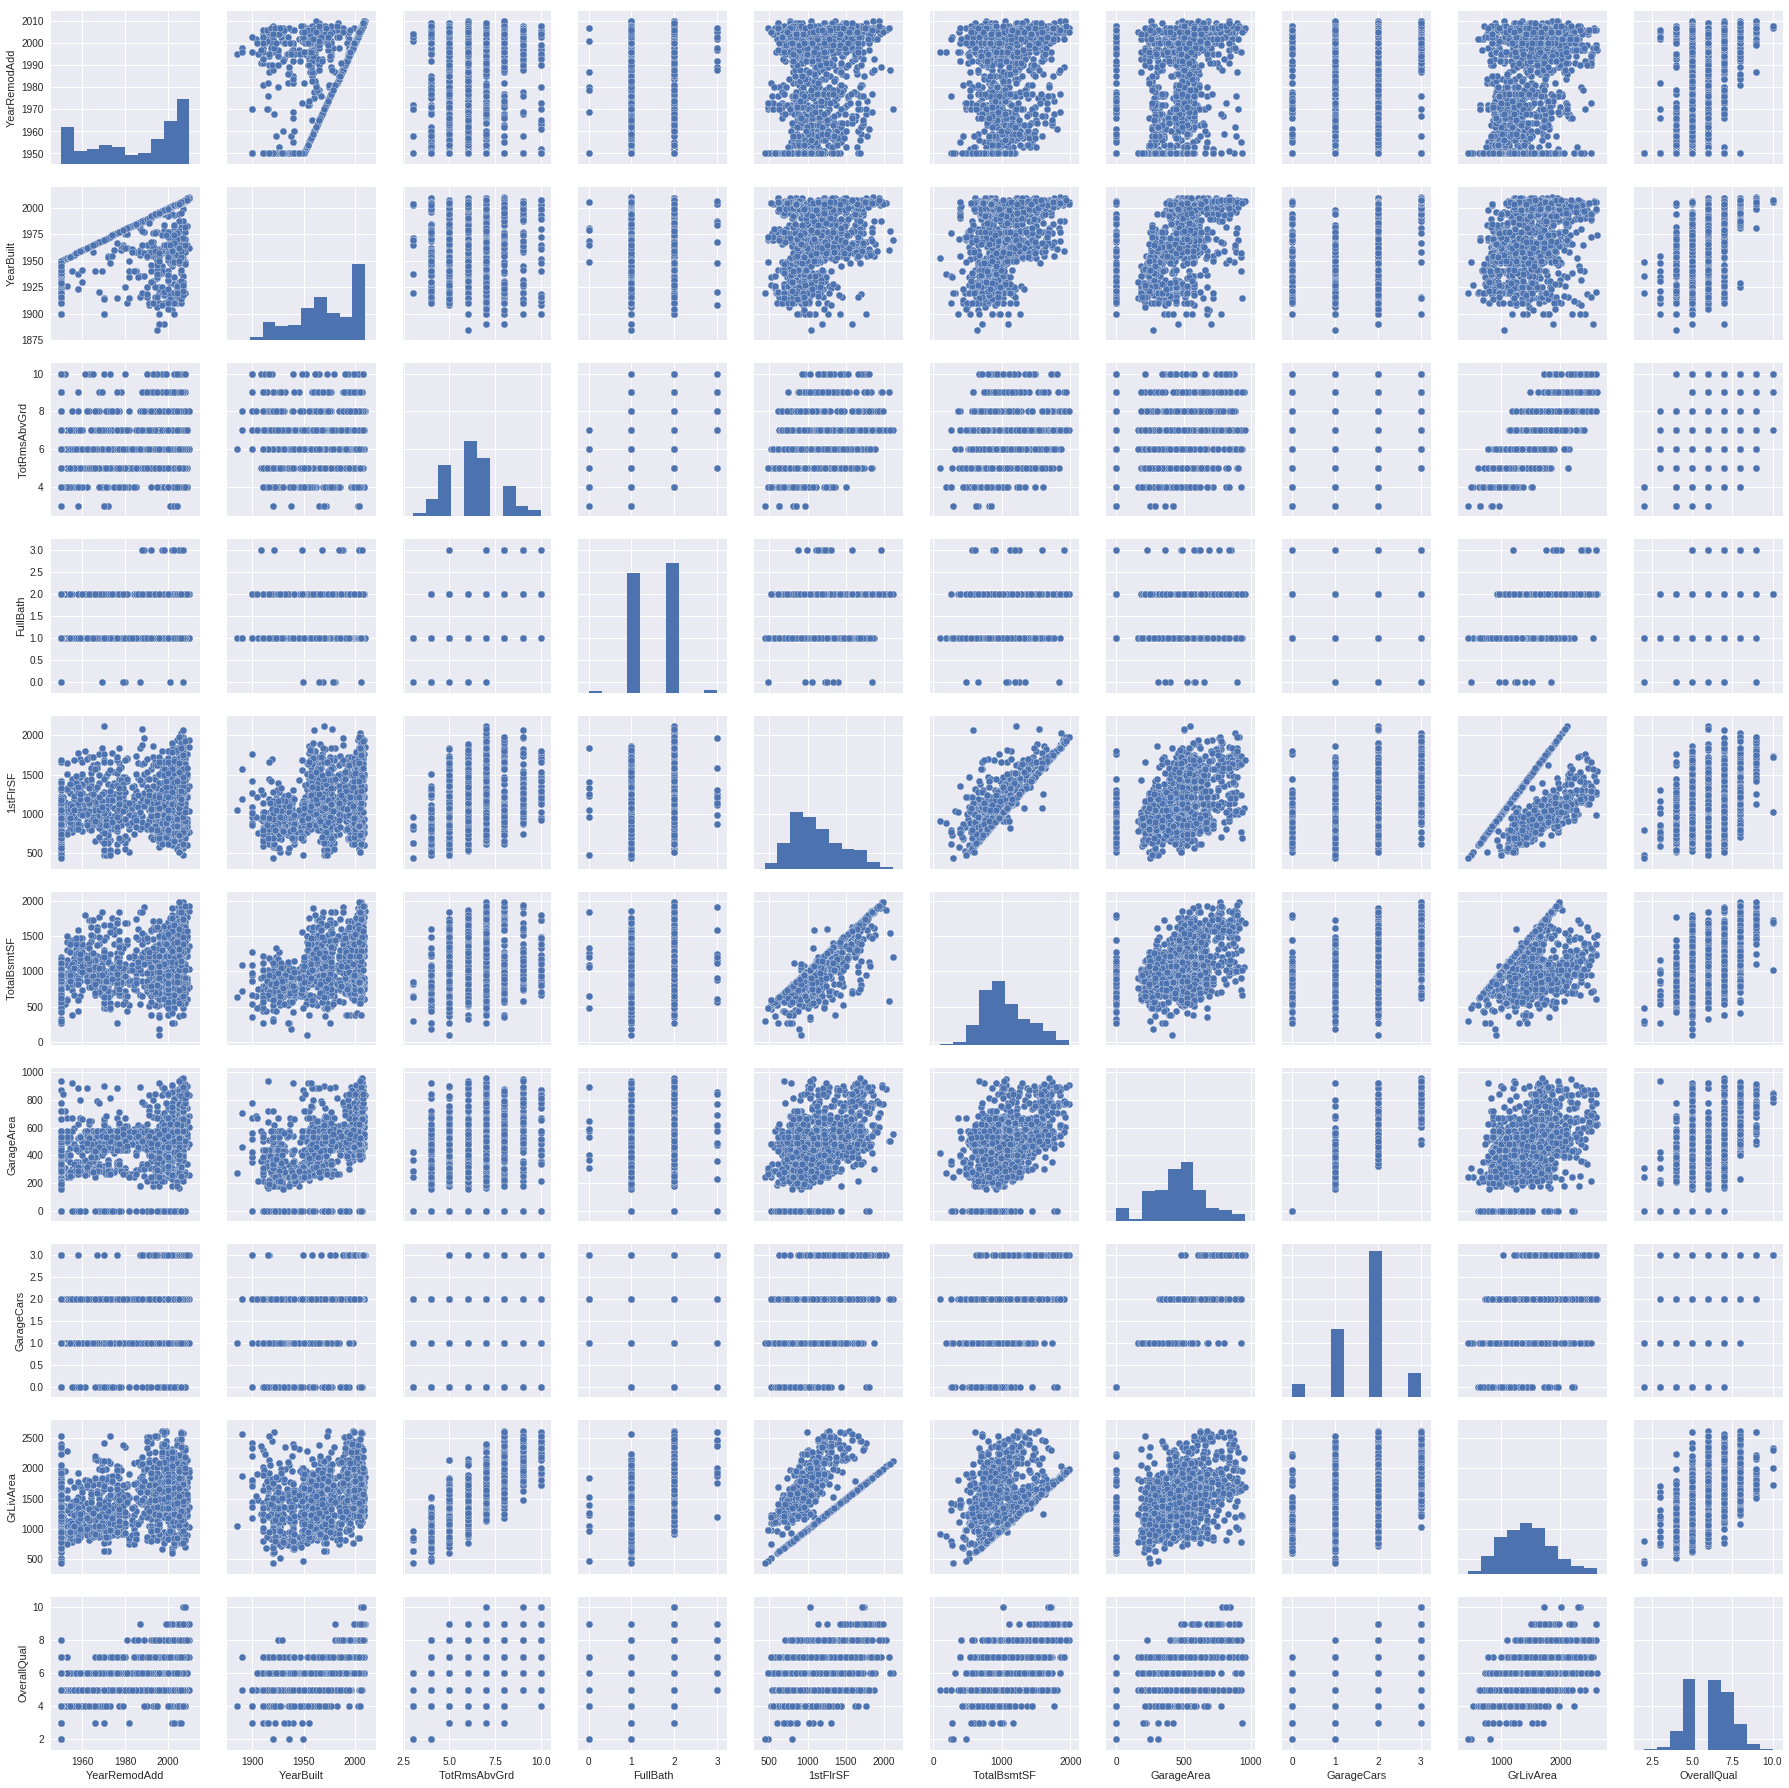

In [56]:
sns.pairplot(X3)

## 2.6 Use seaborn's residplot to plot the distribution of each x variable's residuals. Does these plots indicate any other features that would be potential candidates for polynomial features.

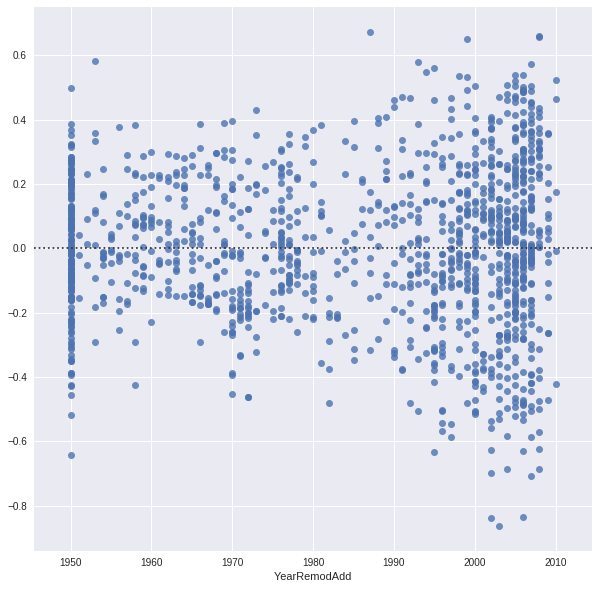

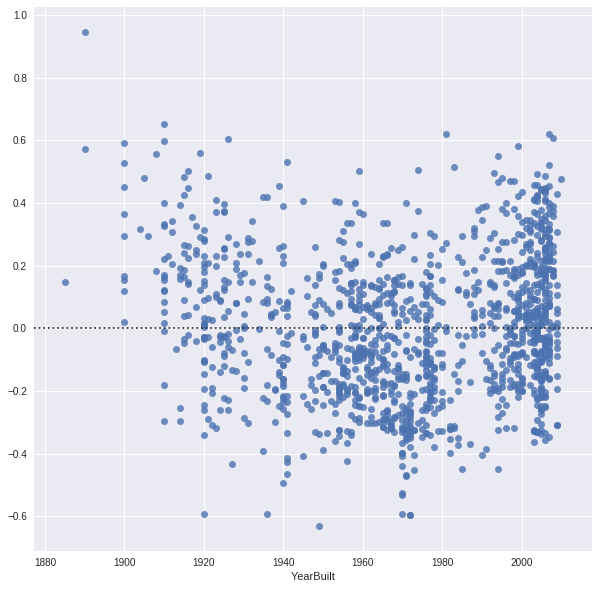

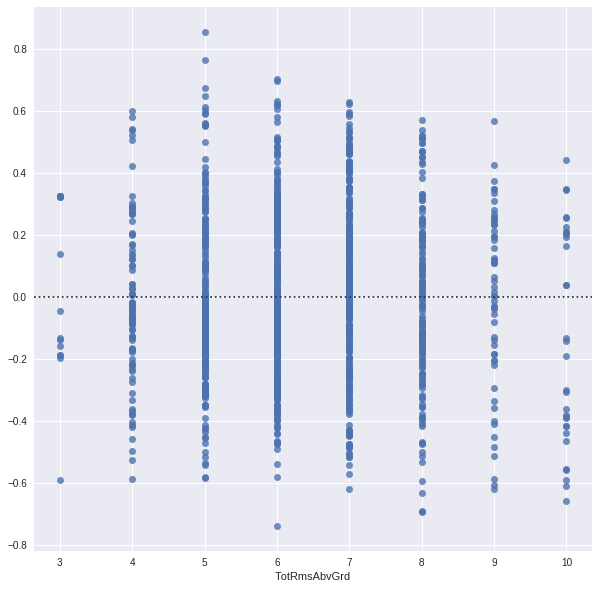

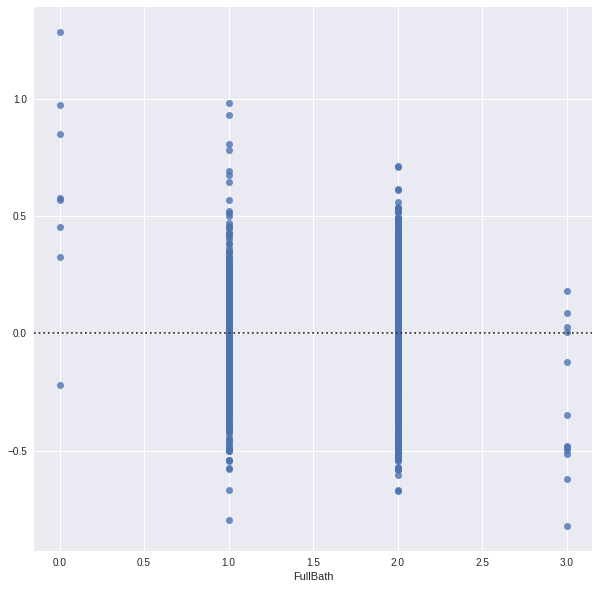

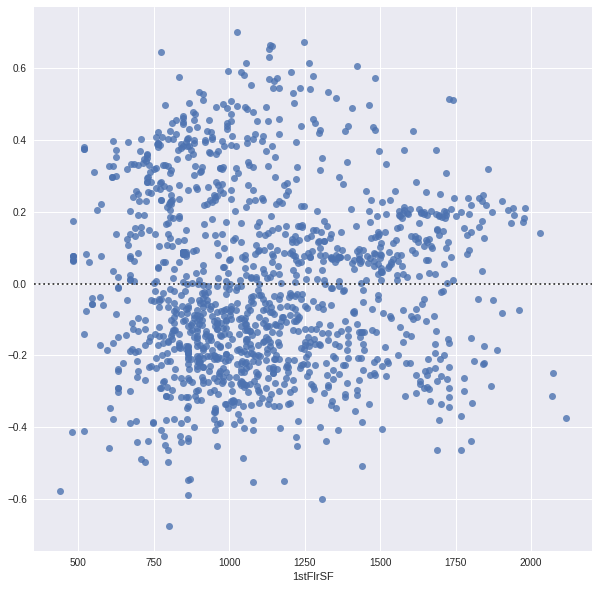

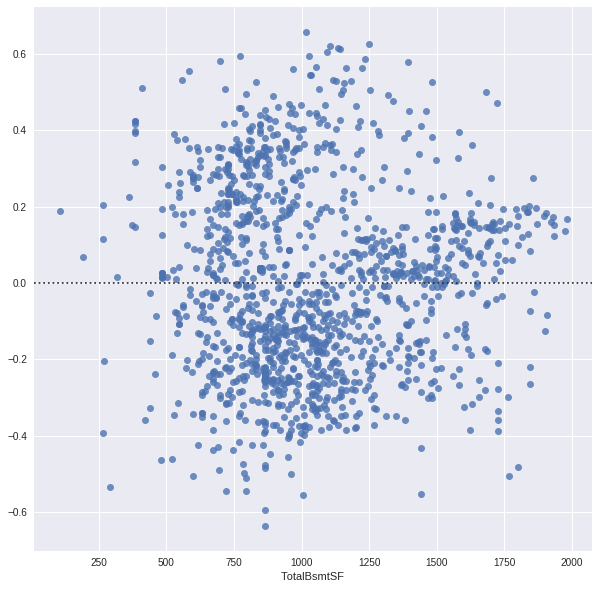

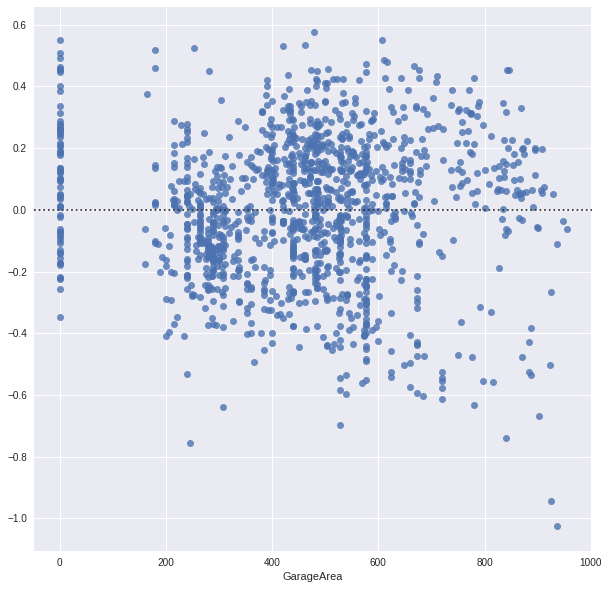

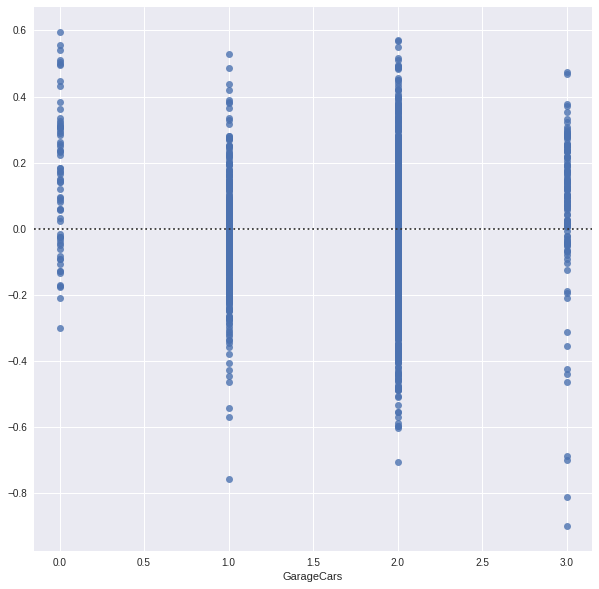

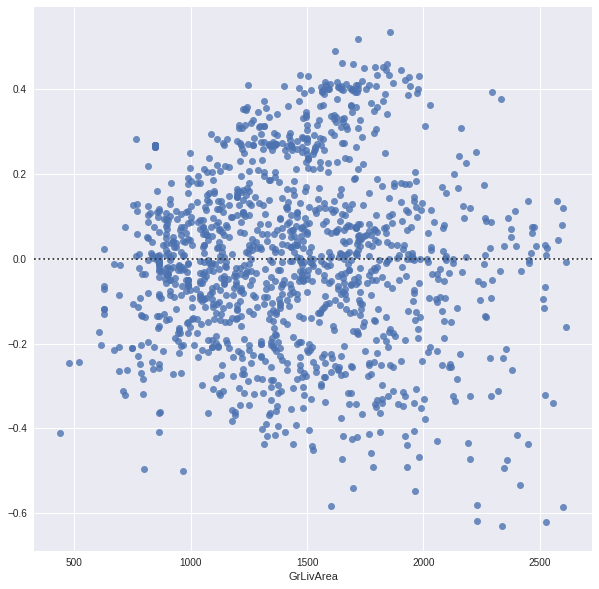

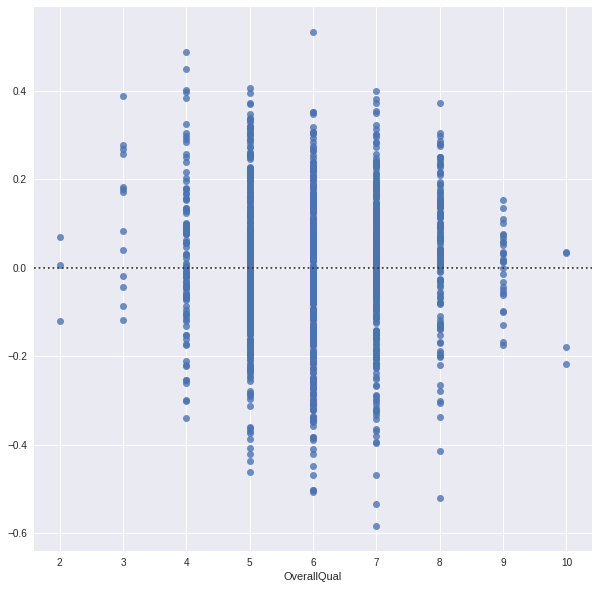

In [62]:
for c in X3:
  fig = plt.figure(figsize=(10,10))
  ax = fig.add_subplot(1,1,1)
  ax.set_xlabel(c)
  sns.residplot(X3[c].values, predictions, ax=ax)
  i += 1
plt.show()

## 2.6 Feature Engineer the appropriate polynomial features from your analysis above and include them in one final log-polynomial, robust standard error, regression. Do the coefficients of this most advanced regression match your intuition better than the coefficients of the very first regression that we ran with the Statmodels library?

In [73]:
rsq = []
for c in X3:
  Xn = X3.copy()
  Xn["{}^2".format(c)] = Xn[c] ** 2
  model = sm.OLS(y2, Xn).fit()
  rsq.append(model.rsquared)
X4 = X3.copy()
ex = list(X3)[rsq.index(max(rsq))]
X4["{}^2".format(ex)] = X4[ex]**2
model = sm.RLM(y2, X4).fit()
print(model.summary())

                    Robust linear Model Regression Results                    
Dep. Variable:              SalePrice   No. Observations:                 1321
Model:                            RLM   Df Residuals:                     1310
Method:                          IRLS   Df Model:                           10
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Fri, 18 Jan 2019                                         
Time:                        01:32:08                                         
No. Iterations:                    28                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
YearRemodAdd     0.0030      0.000     18.071   